In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, Conv2D, InputLayer, Dense, BatchNormalization, MaxPool2D, Dropout, Flatten, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import tensorflow_probability as tfp

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import albumentations as A

In [2]:
train_directory = "C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\Human Emotions\\Dataset\\Emotions Dataset\\Emotions Dataset\\train"
validation_directory = "C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\Human Emotions\\Dataset\\Emotions Dataset\\Emotions Dataset\\test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" : 3
}

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [4]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [5]:
# for i in val_dataset.take(1):
#     print(i)

## Data Visualization

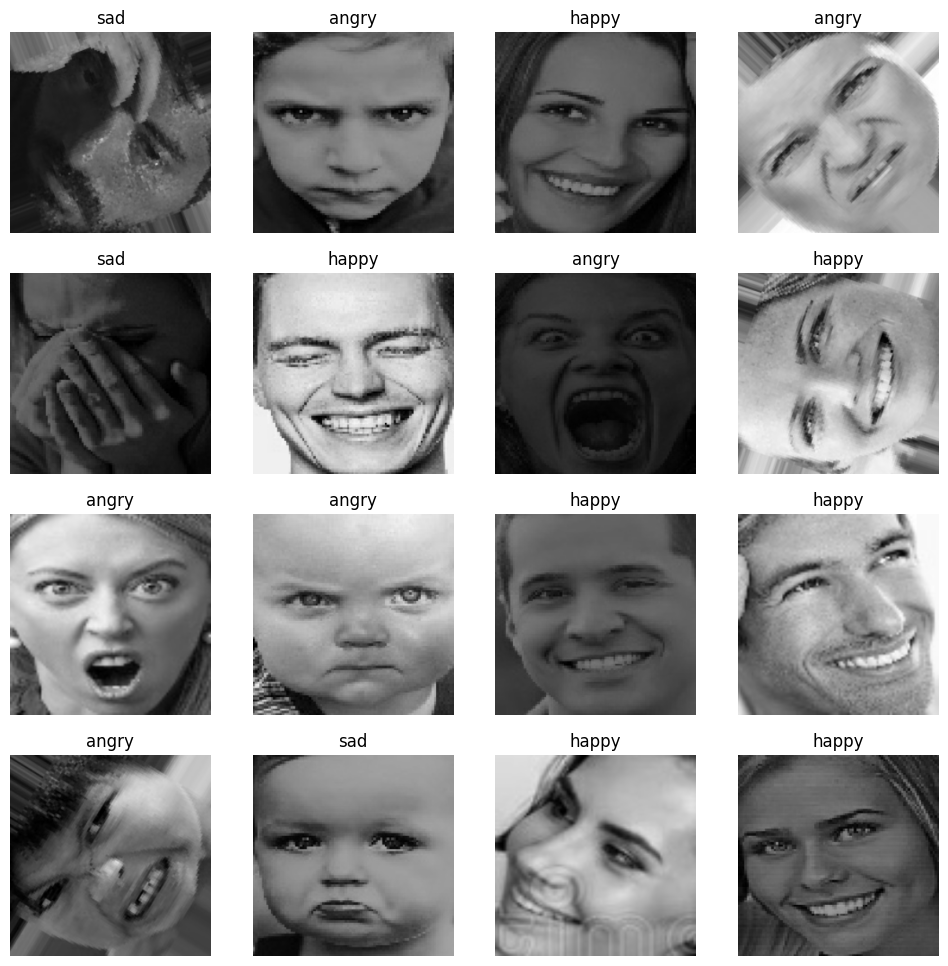

In [6]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")


## Data Augmentation

In [7]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = "horizontal"),
    RandomContrast(factor = 0.1)
])

In [8]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

### Cutmix Augmentation

In [9]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if r_w == 0:
    r_w  = 1

  r_h = y_b_r - r_y
  if r_h == 0:
    r_h = 1

  return r_y, r_x, r_h, r_w


In [10]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label
     

In [11]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [12]:
# training_dataset = mixed_dataset.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

## Dataset Preparation

In [13]:
training_dataset = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
validation_dataset = val_dataset

In [15]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255.)
])

### TFRecords

In [16]:
# train_dataset = training_dataset.unbatch()

In [17]:
# validation_dataset = validation_dataset.unbatch()

In [18]:
# def create_example(image, label):
#     bytes_feature = Feature(bytes_list = BytesList(value = [image]))
#     int_feature = Feature(int64_list = Int64List(value= [label]))

#     example = Example(
#         features = Features(feature = {
#             "images" : bytes_feature,
#             "labels" : int_feature
#         })
#     )

#     return example.SerializeToString()

In [19]:
# NUM_SHARDS = 10
# PATH = "C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\Human Emotions\\tfrecords\\shard_{:02d}.tfrecord"

In [20]:
# def encoder_image(image, label):
#     image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
#     image = tf.io.encode_jpeg(image)
#     return image, tf.argmax(label)

In [21]:
# encoded_dataset = train_dataset.map(encoder_image)

In [22]:
# for shard_number in range(NUM_SHARDS):

#     sharded_dataset = encoded_dataset.shard(NUM_SHARDS, shard_number).as_numpy_iterator()
#     with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#         for image, label in sharded_dataset:
#             file_writer.write(create_example(image, label))

In [23]:
# l = [PATH.format(p) for p in range(NUM_SHARDS)]

In [24]:
# recons_dataset = tf.data.TFRecordDataset(filenames = [PATH.format(p) for p in range(NUM_SHARDS)])

In [25]:
# def parse_tfrecords(example):

#     feature_description = {
#         "images" : tf.io.FixedLenFeature([], tf.string),
#         "labels" : tf.io.FixedLenFeature([], tf.int64)
#     }
#     example = tf.io.parse_single_example(example, feature_description)
#     example["images"] = tf.io.decode_jpeg(example["images"], channels = 3)

#     return example["images"], example["labels"]

In [26]:
# parsed_dataset = (recons_dataset.map(parse_tfrecords)
#                   .batch(CONFIGURATION["BATCH_SIZE"])
#                   .prefetch(tf.data.AUTOTUNE))

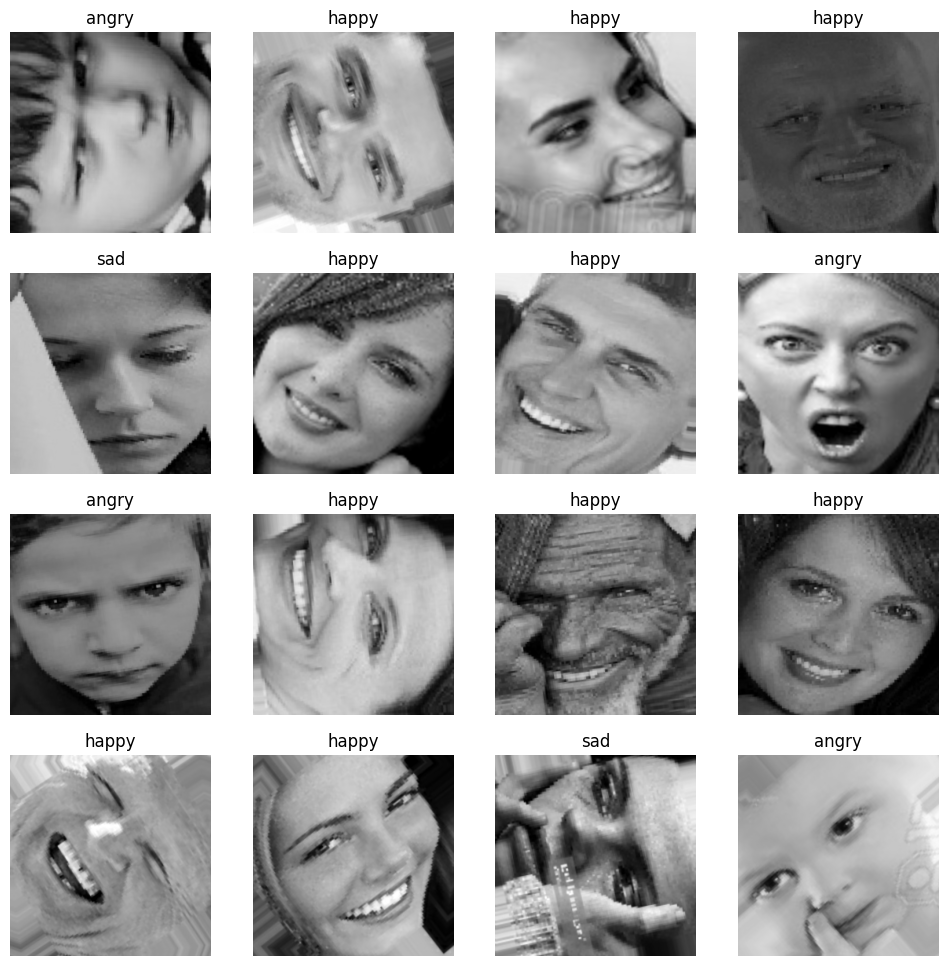

In [27]:
plt.figure(figsize=(12,12))

for images, labels in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

## Modeling

In [28]:
# Lenet Model
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"], kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"],
           activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"],
           activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["N_DENSE_2"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax")
])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## Training

In [29]:
loss_function = tf.keras.losses.CategoricalCrossentropy()

In [30]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [31]:
lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
                    loss = loss_function,
                    metrics = metrics)

In [32]:
history = lenet_model.fit(training_dataset,
                          validation_data = validation_dataset,
                          epochs = CONFIGURATION["N_EPOCHS"])

Epoch 1/20
213/213 [==============================] - 32s 113ms/step - loss: 0.9509 - accuracy: 0.5555 - top_k_accuracy: 0.8275 - val_loss: 1.0484 - val_accuracy: 0.4478 - val_top_k_accuracy: 0.7744
Epoch 2/20
213/213 [==============================] - 16s 73ms/step - loss: 0.8323 - accuracy: 0.6282 - top_k_accuracy: 0.8591 - val_loss: 1.0872 - val_accuracy: 0.5105 - val_top_k_accuracy: 0.7880
Epoch 3/20
213/213 [==============================] - 16s 71ms/step - loss: 0.7632 - accuracy: 0.6675 - top_k_accuracy: 0.8865 - val_loss: 0.7960 - val_accuracy: 0.6523 - val_top_k_accuracy: 0.8788
Epoch 4/20
213/213 [==============================] - 16s 71ms/step - loss: 0.6979 - accuracy: 0.6957 - top_k_accuracy: 0.8990 - val_loss: 0.7374 - val_accuracy: 0.6835 - val_top_k_accuracy: 0.8885
Epoch 5/20
213/213 [==============================] - 14s 65ms/step - loss: 0.6418 - accuracy: 0.7278 - top_k_accuracy: 0.9081 - val_loss: 0.8031 - val_accuracy: 0.6449 - val_top_k_accuracy: 0.8727
Epoch 6/2

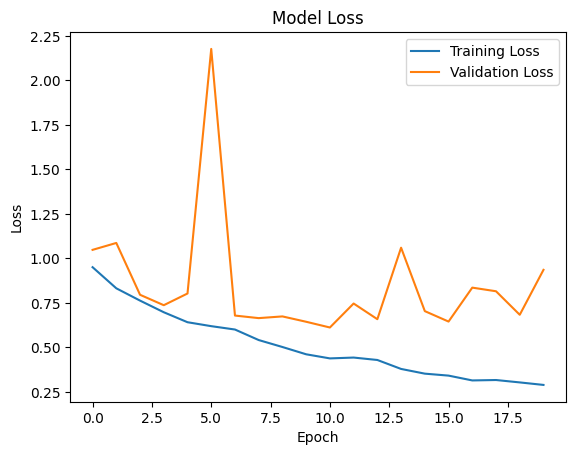

In [33]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

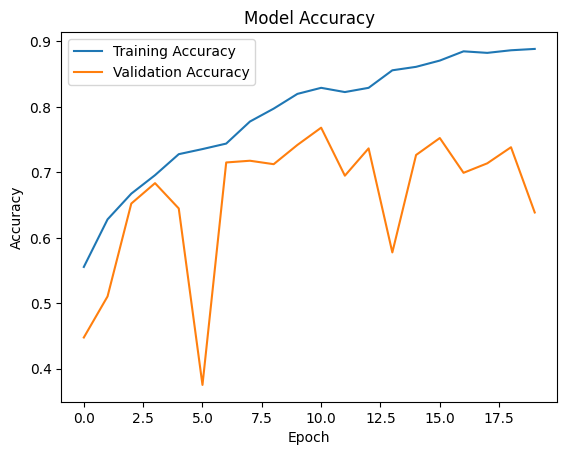

In [34]:
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Evaluation

In [35]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 2s 22ms/step - loss: 0.9361 - accuracy: 0.6387 - top_k_accuracy: 0.8854


[0.9360787868499756, 0.6387181878089905, 0.8854258060455322]

## Testing

In [36]:
test_image = cv2.imread("C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\Human Emotions\\Dataset\\Emotions Dataset\\Emotions Dataset\\test\sad\\108893.jpg")

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = 1).numpy()[0]])

sad


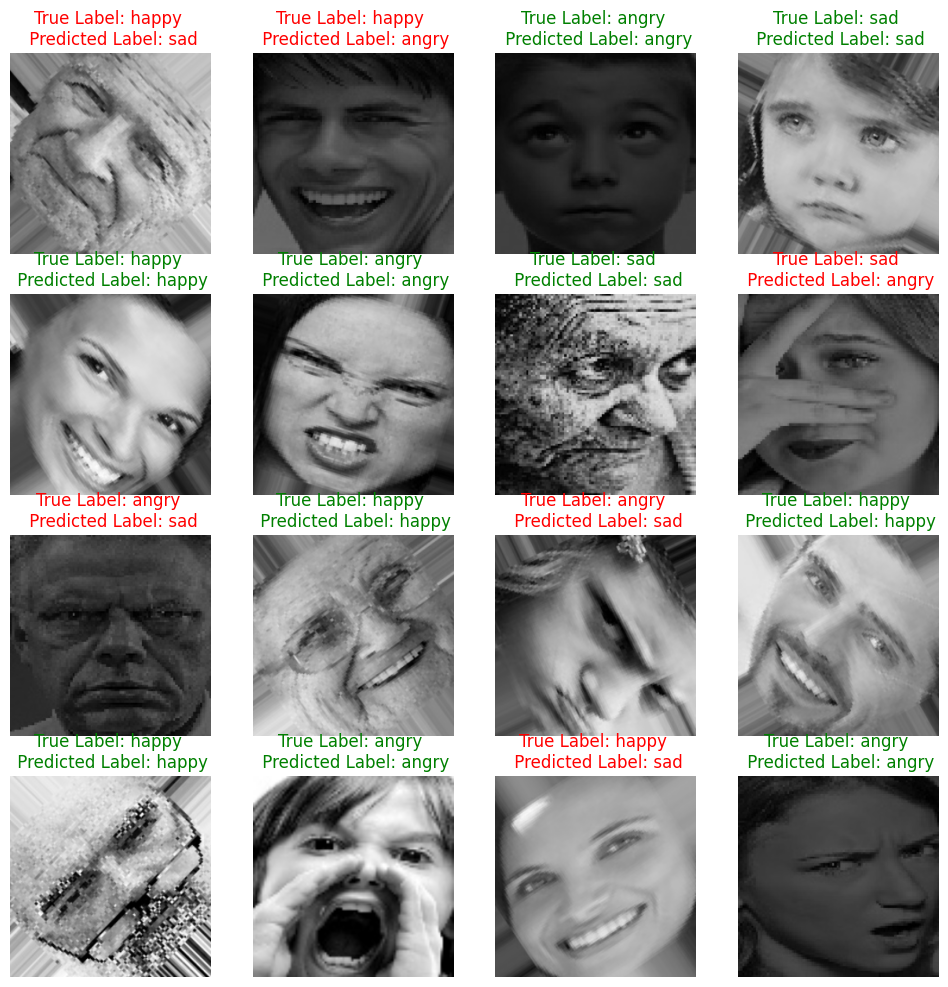

In [37]:
plt.figure(figsize=(12,12))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        predicted_label = CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = 1).numpy()[0]]
        true_label = CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]
        if predicted_label == true_label:
            plt.title(f"True Label: {true_label} \n Predicted Label: {predicted_label}", color = "green")
        else:
            plt.title(f"True Label: {true_label} \n Predicted Label: {predicted_label}", color = "red")
        plt.axis("off")


## Confusion Matrix

In [38]:
labels = []
predicted = []

for im, label in validation_dataset:
    labels.append(label.numpy())
    predicted.append(lenet_model(im))

In [39]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 0 1 ... 2 2 2]
[1 0 0 ... 0 2 2]


In [40]:
pred = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[332 178 203]
 [ 76 676 107]
 [107 152 447]]


Text(0.5, 58.7222222222222, 'Predicted')

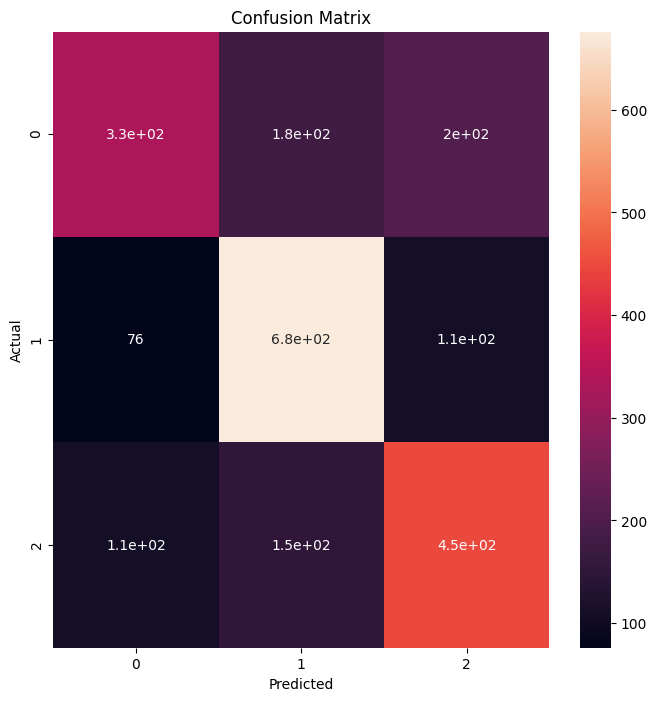

In [41]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot = True)
plt.title(f"Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")